### 1° Problema de Negócio 
#### Regressão para análise de Burnout

    Employee ID: The unique ID allocated for each employee (example: fffe390032003000)

    Date of Joining: The date-time when the employee has joined the organization (example: 2008-12-30)

    Gender: The gender of the employee (Male/Female)

    Company Type: The type of company where the employee is working (Service/Product)

    WFH Setup Available: Whether proper work from home setup is available or not (Yes/No)

    Designation: Seniority level of the employee in codes.
        In the range of [0.0, 5.0] bigger is higher seniority.

    Resource Allocation: Hours allocated per day
        In the range of [1.0, 10.0] (higher means more resource)

    Mental Fatigue Score: Stress rating provided by employees.
        In the range of [0.0, 10.0] where 0.0 means no fatigue and 10.0 means completely fatigue.

    Burn Rate: Rate of saturation or burn out rate .
        In the range of [0.0, 1.0] where the higher the value is more is the burn out.



In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn import metrics
import statistics  as sts
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('base/train.csv')

In [3]:
df.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


In [4]:
df.shape

(22750, 9)

In [5]:
#Traduzir colunas
df.columns

Index(['Employee ID', 'Date of Joining', 'Gender', 'Company Type',
       'WFH Setup Available', 'Designation', 'Resource Allocation',
       'Mental Fatigue Score', 'Burn Rate'],
      dtype='object')

In [6]:
df.columns = ['id','data_adm','genero','tipo_empresa','ambi_dome_favoravel','nivel_senioridade',
             'horas_trab_dias','nivel_fadiga_mental','taxa_burnout']

In [7]:
df.shape

(22750, 9)

In [8]:
df.head()

,id,data_adm,genero,tipo_empresa,ambi_dome_favoravel,nivel_senioridade,horas_trab_dias,nivel_fadiga_mental,taxa_burnout
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22750 entries, 0 to 22749
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   22750 non-null  object 
 1   data_adm             22750 non-null  object 
 2   genero               22750 non-null  object 
 3   tipo_empresa         22750 non-null  object 
 4   ambi_dome_favoravel  22750 non-null  object 
 5   nivel_senioridade    22750 non-null  float64
 6   horas_trab_dias      21369 non-null  float64
 7   nivel_fadiga_mental  20633 non-null  float64
 8   taxa_burnout         21626 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.6+ MB


In [178]:
df.isnull().sum()

id                        0
data_adm                  0
genero                    0
tipo_empresa              0
ambi_dome_favoravel       0
nivel_senioridade         0
horas_trab_dias        1381
nivel_fadiga_mental    2117
taxa_burnout           1124
dtype: int64

### Obs:
* Vou remover a taxa_bounout vazia, depois eu vou calcular as outra para substituir os valores nulos pela media, mediana ou moda. Depois eu volto e faço a regressão para o burnout_rate.


In [179]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
nivel_senioridade,22750.0,2.178725,1.135145,0.0,1.00,2.00,3.00,5.0
horas_trab_dias,21369.0,4.481398,2.047211,1.0,3.00,4.00,6.00,10.0
nivel_fadiga_mental,20633.0,5.728188,1.920839,0.0,4.60,5.90,7.10,10.0
taxa_burnout,21626.0,0.452005,0.198226,0.0,0.31,0.45,0.59,1.0


In [180]:
#Skewnees -  Assimetria
#g1 = 0, a distribuição é simétrica;
#g1 > 0, a distribuição é assimétrica positiva (à direita);
#g1 < 0, a distribuição é assimétrica negativa (à esquerda).
#1) Verifique o sinal: se (-) assimetria à esquerda e se (+) assimetria à direita; 
#2) Se o seu valor estiver próximo de zero, isto é, dentro do intervalo [ -1 ,+ 1], os 
#dados serão mais simétricos, caso contrário, terão alto grau de assimetria.
df.skew()

nivel_senioridade      0.092421
horas_trab_dias        0.204573
nivel_fadiga_mental   -0.430895
taxa_burnout           0.045737
dtype: float64

In [181]:
#Kurtosis - Curtose
##Curtose vai dizer o grau de achatamento da distruição normal
#Quando a curtose é igual a 3, eu tenho uma distribuição normal dos dados
#Todas estão abaixo da normal. Se tiver uma apenas, mesmo nesse caso temos que fazer a  
#normalização
df.kurt()

nivel_senioridade     -0.414916
horas_trab_dias       -0.479884
nivel_fadiga_mental    0.174277
taxa_burnout          -0.261579
dtype: float64

In [182]:
df.dropna(subset=["taxa_burnout"],inplace=True)
df.isnull().sum()

id                        0
data_adm                  0
genero                    0
tipo_empresa              0
ambi_dome_favoravel       0
nivel_senioridade         0
horas_trab_dias        1278
nivel_fadiga_mental    1945
taxa_burnout              0
dtype: int64

### 2° AED e Pré-Processamento dos Dados

In [183]:
df.drop(['id'],axis=1, inplace=True)
display(df)

,data_adm,genero,tipo_empresa,ambi_dome_favoravel,nivel_senioridade,horas_trab_dias,nivel_fadiga_mental,taxa_burnout
0,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52
...,...,...,...,...,...,...,...,...
22745,2008-12-30,Female,Service,No,1.0,3.0,NaN,0.41
22746,2008-01-19,Female,Product,Yes,3.0,6.0,6.7,0.59
22747,2008-11-05,Male,Service,Yes,3.0,7.0,NaN,0.72
22748,2008-01-10,Female,Service,No,2.0,5.0,5.9,0.52


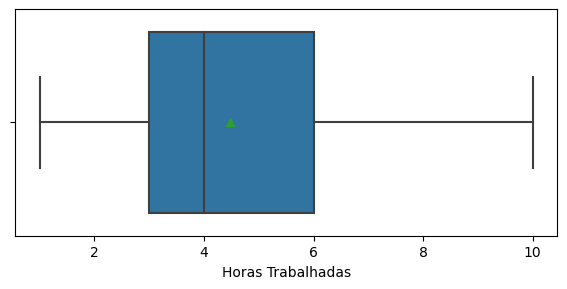

In [184]:
#horas_trab_dias Numérica - contínuo
#Boxplot
plt.figure(figsize=(7,3),dpi=100)
ax = sns.boxplot(df['horas_trab_dias'],showmeans=True)
plt.xlabel('Horas Trabalhadas')
plt.show()

In [185]:
df['horas_trab_dias'].describe()

count    20348.000000
mean         4.483831
std          2.048170
min          1.000000
25%          3.000000
50%          4.000000
75%          6.000000
max         10.000000
Name: horas_trab_dias, dtype: float64

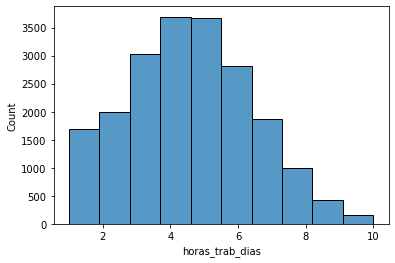

In [186]:
#Histograma
#plt.figure(figsize=(7,3),dpi=100)
#sns.distplot(df['horas_trab_dias']).set_title('Horas trabalahadas por dia')
#plt.show()
sns.histplot(data=df, x='horas_trab_dias', bins=10);

In [187]:
#Distribuição assimétrica positiva. Calda longo à direita
#Vou usar a mediana. A média é apenas se a distribuição estiver normal.
mediana = df['horas_trab_dias'].median()
mediana

4.0

In [188]:
#Trocando pela mediana
df['horas_trab_dias'].fillna(mediana, inplace=True)

In [189]:
df.isnull().sum()

data_adm                  0
genero                    0
tipo_empresa              0
ambi_dome_favoravel       0
nivel_senioridade         0
horas_trab_dias           0
nivel_fadiga_mental    1945
taxa_burnout              0
dtype: int64

In [190]:
#nivel_fadiga_mentals Numérica - contínuo
df['nivel_fadiga_mental'].describe()

count    19681.000000
mean         5.729851
std          1.920784
min          0.000000
25%          4.600000
50%          5.900000
75%          7.100000
max         10.000000
Name: nivel_fadiga_mental, dtype: float64

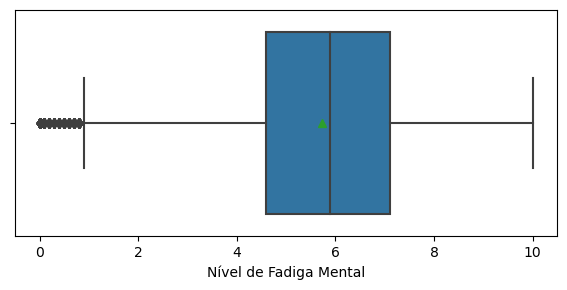

In [191]:
#horas_trab_dias Numérica - contínuo
#Boxplot
plt.figure(figsize=(7,3),dpi=100)
ax = sns.boxplot(df['nivel_fadiga_mental'],showmeans=True)
plt.xlabel('Nível de Fadiga Mental')
plt.show()

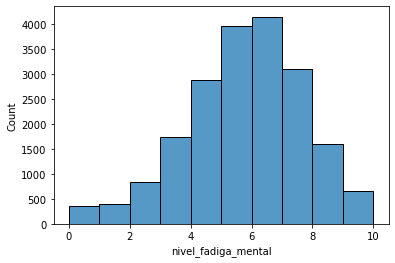

In [192]:
sns.histplot(data=df, x='nivel_fadiga_mental', bins=10);

In [193]:
mediana = df['nivel_fadiga_mental'].median()
mediana

5.9

In [194]:
#Trocando pela mediana
df['nivel_fadiga_mental'].fillna(mediana, inplace=True)

In [195]:
df.isnull().sum()

data_adm               0
genero                 0
tipo_empresa           0
ambi_dome_favoravel    0
nivel_senioridade      0
horas_trab_dias        0
nivel_fadiga_mental    0
taxa_burnout           0
dtype: int64

In [196]:
#Vamos formatar a data para datetime
df['data_adm'] = pd.to_datetime(df['data_adm'])
df.head()

,data_adm,genero,tipo_empresa,ambi_dome_favoravel,nivel_senioridade,horas_trab_dias,nivel_fadiga_mental,taxa_burnout
0,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,2008-03-10,Female,Product,Yes,2.0,4.0,5.8,0.49
3,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


In [197]:
#Calculando os dias de empresa
import datetime
df['dias_empresa'] = pd.to_datetime(datetime.date.today()) - pd.to_datetime(df['data_adm'])

In [198]:
df.head()

,data_adm,genero,tipo_empresa,ambi_dome_favoravel,nivel_senioridade,horas_trab_dias,nivel_fadiga_mental,taxa_burnout,dias_empresa
0,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16,5341 days
1,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36,5280 days
2,2008-03-10,Female,Product,Yes,2.0,4.0,5.8,0.49,5545 days
3,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20,5307 days
4,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52,5409 days


In [199]:
df['dias_empresa'] = df['dias_empresa'].dt.days
df.head()

,data_adm,genero,tipo_empresa,ambi_dome_favoravel,nivel_senioridade,horas_trab_dias,nivel_fadiga_mental,taxa_burnout,dias_empresa
0,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16,5341
1,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36,5280
2,2008-03-10,Female,Product,Yes,2.0,4.0,5.8,0.49,5545
3,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20,5307
4,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52,5409


In [200]:
#Remove o campo data
df.drop(['data_adm'],axis=1, inplace = True)
df.head()

,genero,tipo_empresa,ambi_dome_favoravel,nivel_senioridade,horas_trab_dias,nivel_fadiga_mental,taxa_burnout,dias_empresa
0,Female,Service,No,2.0,3.0,3.8,0.16,5341
1,Male,Service,Yes,1.0,2.0,5.0,0.36,5280
2,Female,Product,Yes,2.0,4.0,5.8,0.49,5545
3,Male,Service,Yes,1.0,1.0,2.6,0.20,5307
4,Female,Service,No,3.0,7.0,6.9,0.52,5409


In [202]:
#Verificando os dados duplicados
df[df.duplicated(keep=False)]

,genero,tipo_empresa,ambi_dome_favoravel,nivel_senioridade,horas_trab_dias,nivel_fadiga_mental,taxa_burnout,dias_empresa
530,Female,Service,No,1.0,3.0,4.4,0.29,5459
2900,Male,Product,No,4.0,7.0,6.7,0.56,5507
3076,Female,Service,Yes,0.0,1.0,0.0,0.00,5388
4139,Female,Service,No,3.0,6.0,7.7,0.58,5415
7653,Male,Service,No,3.0,6.0,8.6,0.68,5435
8306,Female,Service,No,3.0,6.0,7.7,0.58,5415
10938,Female,Service,No,3.0,7.0,5.9,0.74,5600
11760,Female,Service,No,2.0,5.0,5.9,0.59,5518
11833,Female,Service,Yes,1.0,2.0,4.0,0.24,5562
12809,Male,Product,No,4.0,7.0,6.7,0.56,5507


In [203]:
#Para deletar se tiver. Apenas o primeiro
df.drop_duplicates(keep='first', inplace=True)

In [204]:
#Verificando os dados duplicados
df[df.duplicated(keep=False)]

,genero,tipo_empresa,ambi_dome_favoravel,nivel_senioridade,horas_trab_dias,nivel_fadiga_mental,taxa_burnout,dias_empresa


In [205]:
df.shape

(21617, 8)

In [206]:
#Anallisando o ambi_dome_favoravel
group = df.groupby(['ambi_dome_favoravel']).size()
group

ambi_dome_favoravel
No      9934
Yes    11683
dtype: int64

In [208]:
df = pd.get_dummies(df, columns=['ambi_dome_favoravel'])
df.head()

,genero,tipo_empresa,nivel_senioridade,horas_trab_dias,nivel_fadiga_mental,taxa_burnout,dias_empresa,ambi_dome_favoravel_No,ambi_dome_favoravel_Yes
0,Female,Service,2.0,3.0,3.8,0.16,5341,1,0
1,Male,Service,1.0,2.0,5.0,0.36,5280,0,1
2,Female,Product,2.0,4.0,5.8,0.49,5545,0,1
3,Male,Service,1.0,1.0,2.6,0.20,5307,0,1
4,Female,Service,3.0,7.0,6.9,0.52,5409,1,0


In [209]:
#Analisando o genero
group = df.groupby(['genero']).size()
group

genero
Female    11343
Male      10274
dtype: int64

In [210]:
df = pd.get_dummies(df, columns=['genero'])

In [211]:
df.head()

,tipo_empresa,nivel_senioridade,horas_trab_dias,nivel_fadiga_mental,taxa_burnout,dias_empresa,ambi_dome_favoravel_No,ambi_dome_favoravel_Yes,genero_Female,genero_Male
0,Service,2.0,3.0,3.8,0.16,5341,1,0,1,0
1,Service,1.0,2.0,5.0,0.36,5280,0,1,0,1
2,Product,2.0,4.0,5.8,0.49,5545,0,1,1,0
3,Service,1.0,1.0,2.6,0.20,5307,0,1,0,1
4,Service,3.0,7.0,6.9,0.52,5409,1,0,1,0


In [212]:
#Analisando o tipo_empresa
group = df.groupby(['tipo_empresa']).size()
group

tipo_empresa
Product     7501
Service    14116
dtype: int64

In [213]:
df = pd.get_dummies(df, columns=['tipo_empresa'])

In [214]:
df.head()

,nivel_senioridade,horas_trab_dias,nivel_fadiga_mental,taxa_burnout,dias_empresa,ambi_dome_favoravel_No,ambi_dome_favoravel_Yes,genero_Female,genero_Male,tipo_empresa_Product,tipo_empresa_Service
0,2.0,3.0,3.8,0.16,5341,1,0,1,0,0,1
1,1.0,2.0,5.0,0.36,5280,0,1,0,1,0,1
2,2.0,4.0,5.8,0.49,5545,0,1,1,0,1,0
3,1.0,1.0,2.6,0.20,5307,0,1,0,1,0,1
4,3.0,7.0,6.9,0.52,5409,1,0,1,0,0,1


In [215]:
#Verificando os dados duplicados
df[df.duplicated(keep=False)]

,nivel_senioridade,horas_trab_dias,nivel_fadiga_mental,taxa_burnout,dias_empresa,ambi_dome_favoravel_No,ambi_dome_favoravel_Yes,genero_Female,genero_Male,tipo_empresa_Product,tipo_empresa_Service


In [141]:
#Para deletar se tiver. Apenas o primeiro
#df.drop_duplicates(keep='first', inplace=True)

In [142]:
#Tirando a prova se deletou mesmo
#df[df.duplicated(keep=False)]

,genero,tipo_empresa,ambi_dome_favoravel,nivel_senioridade,horas_trab_dias,nivel_fadiga_mental,taxa_burnout,dias_empresa


In [216]:
#Correlação
df.corr()['taxa_burnout']

nivel_senioridade          0.737505
horas_trab_dias            0.829581
nivel_fadiga_mental        0.898951
taxa_burnout               1.000000
dias_empresa               0.001186
ambi_dome_favoravel_No     0.306056
ambi_dome_favoravel_Yes   -0.306056
genero_Female             -0.154789
genero_Male                0.154789
tipo_empresa_Product      -0.004298
tipo_empresa_Service       0.004298
Name: taxa_burnout, dtype: float64

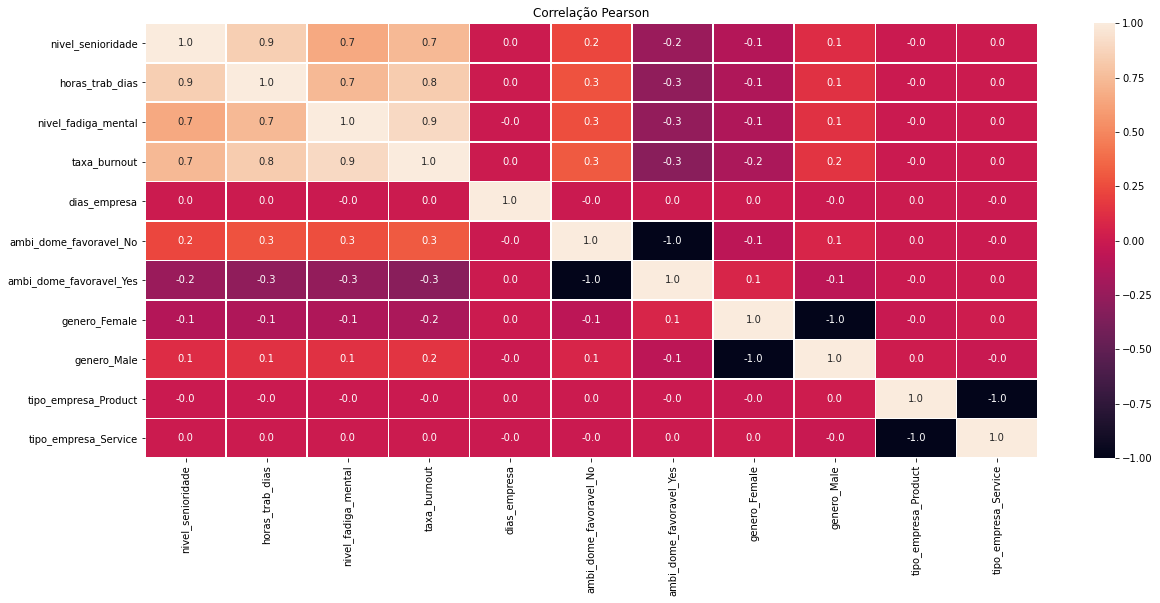

In [217]:
# Correlação Pearson para regressão 
fig, ax = plt.subplots(figsize=(20,8))
ax = sns.heatmap(df.corr(method='pearson'), annot = True, fmt=".1f", linewidths=.6)
ax.set_title('Correlação Pearson')
plt.show()

In [144]:
#AED com dataprep
from dataprep.eda import create_report

In [145]:
create_report(df).show_browser()

  0%|                                           | 0/1158 [00:00<?, ?it/s]

In [273]:
#Salvar o dataset
#df.to_csv('base/train_processado.csv')
#Carregar
df = pd.read_csv('base/train_processado.csv',error_bad_lines=False)
#df = pd.read_csv('base/train_processado_notnull.csv',error_bad_lines=False)

In [274]:
df.size

259404

In [275]:
df.isnull().sum()

Unnamed: 0                 0
nivel_senioridade          0
horas_trab_dias            0
nivel_fadiga_mental        0
taxa_burnout               0
dias_empresa               0
ambi_dome_favoravel_No     0
ambi_dome_favoravel_Yes    0
genero_Female              0
genero_Male                0
tipo_empresa_Product       0
tipo_empresa_Service       0
dtype: int64

In [261]:
#Verificar a balanceamento das classe não precisa, pois farei regressão.
#Vamos direto para a normalização, ma antes separar entre treino e teste
#X = df.iloc[:,:-1].values  #variáveis independentes
#y = df.iloc[:,-1].values  #Target/labe/class/vairável dependente
#Carregando o que foi calculado
#X = df.drop(['taxa_burnout'], axis=1)
#y = df['taxa_burnout']

In [276]:
#X = df.drop(['taxa_burnout','dias_empresa','tipo_empresa_Produc','tipo_empresa_Service'], axis=1)
X = df.drop(['taxa_burnout','dias_empresa',"Unnamed: 0"], axis=1)
y = df['taxa_burnout']

In [277]:
display(X)

,nivel_senioridade,horas_trab_dias,nivel_fadiga_mental,ambi_dome_favoravel_No,ambi_dome_favoravel_Yes,genero_Female,genero_Male,tipo_empresa_Product,tipo_empresa_Service
0,2.0,3.0,3.8,1,0,1,0,0,1
1,1.0,2.0,5.0,0,1,0,1,0,1
2,2.0,4.0,5.8,0,1,1,0,1,0
3,1.0,1.0,2.6,0,1,0,1,0,1
4,3.0,7.0,6.9,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...
21612,1.0,3.0,5.9,1,0,1,0,0,1
21613,3.0,6.0,6.7,0,1,1,0,1,0
21614,3.0,7.0,5.9,0,1,0,1,0,1
21615,2.0,5.0,5.9,1,0,1,0,0,1


In [278]:
display(y)

0        0.16
1        0.36
2        0.49
3        0.20
4        0.52
         ... 
21612    0.41
21613    0.59
21614    0.72
21615    0.52
21616    0.61
Name: taxa_burnout, Length: 21617, dtype: float64

In [279]:
#Divide o dataset em Train and Test 
X_train, X_test, y_train, y_test = train_test_split(X ,y, test_size=0.3, random_state = 7) 

In [280]:
print(f"Shape dos dados de treino é {X_train.shape}")
print(f"Shape dos dados de teste é {X_test.shape}")

Shape dos dados de treino é (15131, 9)
Shape dos dados de teste é (6486, 9)


In [281]:
#Redimensionando os dados - PADRONIZAÇÂO - Feature scaling
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import MinMaxScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test) 


#minmax = MinMaxScaler()
#X_train = minmax.fit_transform(X_train)
#X_test = minmax.transform(X_test) 


print("\n--------------------------------\nDataset depois da padronização:\n--------------------------------\n", )

print("\nX_train :\n", X_train[:5])
print("-------------------------")
print("\nX_test :\n", X_test[:5])


--------------------------------
Dataset depois da padronização:
--------------------------------


X_train :
 [[-0.16162371 -0.23197611 -0.46322122  1.08581926 -1.08581926 -1.05315912
   1.05315912  1.36293856 -1.36293856]
 [ 0.71933029  0.26888441  0.1362765  -0.92096359  0.92096359 -1.05315912
   1.05315912  1.36293856 -1.36293856]
 [ 0.71933029  0.76974492  0.62677463  1.08581926 -1.08581926 -1.05315912
   1.05315912  1.36293856 -1.36293856]
 [-0.16162371 -0.23197611  0.35427567 -0.92096359  0.92096359  0.94952413
  -0.94952413  1.36293856 -1.36293856]
 [-0.16162371 -0.23197611 -0.02722288 -0.92096359  0.92096359 -1.05315912
   1.05315912  1.36293856 -1.36293856]]
-------------------------

X_test :
 [[ 0.71933029  1.27060544  1.17177256  1.08581926 -1.08581926 -1.05315912
   1.05315912 -0.73370879  0.73370879]
 [-0.16162371 -0.23197611  0.46327525 -0.92096359  0.92096359 -1.05315912
   1.05315912  1.36293856 -1.36293856]
 [-1.0425777  -0.23197611 -2.75221252 -0.92096359  0.920963

## 3° Construindo as Máquinas Preditivas

### Regressão Linear

In [282]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

In [283]:
#Regressão Linear
model = LinearRegression()

In [284]:
model.fit(X_train, y_train)

LinearRegression()

In [285]:
y_pred = model.predict(X_test)

### 4°Avaliação do modelo

In [286]:
print(y_test.size)
print(y_pred.size)

6486
6486


In [287]:
# Avaliando o modelo
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:', metrics.mean_squared_error(y_test, y_pred))
print('R2:', metrics.r2_score(y_test, y_pred))

MAE: 0.05380631764158604
RMSE: 0.0050313433599008224
R2: 0.870508429102131


OBS: Um MAE de 0.05381129751520101 é considerado muito bom, especialmente em problemas de regressão. Um valor tão baixo indica que, em média, as previsões feitas pelo modelo estão desviando apenas cerca de 0.05 unidades do valor real. Isso sugere uma alta precisão nas previsões e um ajuste muito próximo aos dados observados.

In [23]:
#Calculando o R2 ajustado
n = len(y_train)

# Número de variáveis independentes (preditoras)
p = X_train.shape[1]
r2_adjusted = 1 - (1 - metrics.r2_score(y_test, y_pred)) * (n - 1) / (n - p - 1)

In [24]:
print('R2 ajustado:', r2_adjusted)

R2 ajustado: 0.8704887448228456


### Aplicando o GridSearch no Regressão Logística

* GridSearchCV não é adequado para ajustar hiperparâmetros de um modelo de Regressão Linear, pois a Regressão Linear possui apenas um hiperparâmetro (interceptação) e não requer ajuste adicional. O GridSearchCV é geralmente usado para modelos que possuem vários hiperparâmetros que podem ser ajustados.

### K vizinhos mais próximos - KNN

In [34]:
from sklearn.neighbors import KNeighborsRegressor

In [35]:
knr = KNeighborsRegressor()

In [37]:
knr.fit(X_train, y_train)

KNeighborsRegressor()

In [38]:
y_pred = knr.predict(X_test)

### Avaliação do modelo

In [39]:
# Avaliando o modelo
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:', metrics.mean_squared_error(y_test, y_pred))
print('R2:', metrics.r2_score(y_test, y_pred))

MAE: 0.05454085723095898
RMSE: 0.005050528522972556
R2: 0.8700146609916318


In [40]:
#Calculando o R2 ajustado
n = len(y_train)

# Número de variáveis independentes (preditoras)
p = X_train.shape[1]
r2_adjusted = 1 - (1 - metrics.r2_score(y_test, y_pred)) * (n - 1) / (n - p - 1)

In [41]:
print('R2 ajustado:', r2_adjusted)

R2 ajustado: 0.869928691852076


### Grid Search para KNN

In [85]:
parameters = {'n_neighbors': [3, 5, 7],
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

In [86]:
grid_search = GridSearchCV(knr, parameters, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=KNeighborsRegressor(algorithm='brute', n_neighbors=7),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [3, 5, 7],
                         'weights': ['uniform', 'distance']})

In [87]:
# Obter os melhores hiperparâmetros
best_params = grid_search.best_params_
print("Melhores hiperparâmetros:", best_params)

Melhores hiperparâmetros: {'algorithm': 'brute', 'n_neighbors': 7, 'weights': 'uniform'}


In [88]:
knr_best = grid_search.best_estimator_

In [89]:
#y_pred = grid_search.predict(X_test)
y_pred = knr_best.predict(X_test)

In [90]:
# Avaliando o modelo
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:', metrics.mean_squared_error(y_test, y_pred))
print('R2:', metrics.r2_score(y_test, y_pred))

MAE: 0.053757763975155276
RMSE: 0.004939595801317752
R2: 0.8728697339539628


In [91]:
#Calculando o R2 ajustado
n = len(y_train)

# Número de variáveis independentes (preditoras)
p = X_train.shape[1]
r2_adjusted = 1 - (1 - metrics.r2_score(y_test, y_pred)) * (n - 1) / (n - p - 1)

In [92]:
print('R2 ajustado:', r2_adjusted)

R2 ajustado: 0.8727856530901758


### Árvore de Decisão

In [36]:
from sklearn.tree import DecisionTreeRegressor

In [37]:
dtr = DecisionTreeRegressor(random_state=7,max_depth=9)

In [61]:
dtr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=9, random_state=7)

In [62]:
y_pred = dtr.predict(X_test)

### Avaliação do modelo

In [63]:
# Avaliando o modelo
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:', metrics.mean_squared_error(y_test, y_pred))
print('R2:', metrics.r2_score(y_test, y_pred))

MAE: 0.049184680598035366
RMSE: 0.004006735166079309
R2: 0.8968787471428761


In [64]:
#Calculando o R2 ajustado
n = len(y_train)

# Número de variáveis independentes (preditoras)
p = X_train.shape[1]
r2_adjusted = 1 - (1 - metrics.r2_score(y_test, y_pred)) * (n - 1) / (n - p - 1)

In [65]:
print('R2 ajustado:', r2_adjusted)

R2 ajustado: 0.8968105452560658


### Grid Search para Árvore de Decisão

In [93]:
# Definir os parâmetros para busca em grade
parameters = {'max_depth': [3, 6, 9],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}


In [94]:
grid_search = GridSearchCV(dtr, parameters, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeRegressor(max_depth=9, min_samples_leaf=4,
                                             min_samples_split=10,
                                             random_state=7),
             param_grid={'max_depth': [3, 6, 9], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]})

In [95]:
best_params = grid_search.best_params_
print("Melhores hiperparâmetros:", best_params)

Melhores hiperparâmetros: {'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 10}


In [96]:
dtr_best = grid_search.best_estimator_

In [97]:
y_pred = dtr_best.predict(X_test)

### Avaliação do modelo

In [98]:
# Avaliando o modelo
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:', metrics.mean_squared_error(y_test, y_pred))
print('R2:', metrics.r2_score(y_test, y_pred))

MAE: 0.04903091245446579
RMSE: 0.0039679412837098586
R2: 0.8978771844209367


In [99]:
#Calculando o R2 ajustado
n = len(y_train)

# Número de variáveis independentes (preditoras)
p = X_train.shape[1]
r2_adjusted = 1 - (1 - metrics.r2_score(y_test, y_pred)) * (n - 1) / (n - p - 1)

In [100]:
print('R2 ajustado:', r2_adjusted)

R2 ajustado: 0.8978096428762415


### Random Forest

In [38]:
from sklearn.ensemble import RandomForestRegressor 

In [39]:
rfr = RandomForestRegressor(random_state=7, n_estimators=100)

In [106]:
rfr.fit(X_train, y_train)

RandomForestRegressor(random_state=7)

In [107]:
y_pred = rfr.predict(X_test)

### Avaliação do modelo

In [108]:
# Avaliando o modelo
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:', metrics.mean_squared_error(y_test, y_pred))
print('R2:', metrics.r2_score(y_test, y_pred))

MAE: 0.0507504933703361
RMSE: 0.004300401968855997
R2: 0.8893206512444365


In [109]:
#Calculando o R2 ajustado
n = len(y_train)

# Número de variáveis independentes (preditoras)
p = X_train.shape[1]
r2_adjusted = 1 - (1 - metrics.r2_score(y_test, y_pred)) * (n - 1) / (n - p - 1)

In [110]:
print('R2 ajustado:', r2_adjusted)

R2 ajustado: 0.8892474506169527


### Grid Search Random Forest

In [114]:
#'n_estimators': [100, 200, 300],
parameters = { 'n_estimators': [50, 100, 150],
              'max_depth': [3, 6, 9],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': ['auto', 'sqrt', 'log2']}

In [115]:
grid_search = GridSearchCV(rfr, parameters, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=7),
             param_grid={'max_depth': [3, 6, 9],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150]})

In [116]:
best_params = grid_search.best_params_
print("Melhores hiperparâmetros:", best_params)

Melhores hiperparâmetros: {'max_depth': 9, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 150}


In [117]:
rfr_best = grid_search.best_estimator_

In [118]:
y_pred = rfr_best.predict(X_test)

### Avaliação do modelo

In [119]:
# Avaliando o modelo
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:', metrics.mean_squared_error(y_test, y_pred))
print('R2:', metrics.r2_score(y_test, y_pred))

MAE: 0.047806432925873873
RMSE: 0.003722081191927542
R2: 0.9042048800736965


In [120]:
#Calculando o R2 ajustado
n = len(y_train)

# Número de variáveis independentes (preditoras)
p = X_train.shape[1]
r2_adjusted = 1 - (1 - metrics.r2_score(y_test, y_pred)) * (n - 1) / (n - p - 1)

In [121]:
print('R2 ajustado:', r2_adjusted)

R2 ajustado: 0.9041415235128987


### SVR

In [40]:
from sklearn.svm import SVR 

In [41]:
svr = SVR() 

In [125]:
svr.fit(X_train, y_train)

SVR()

In [126]:
y_pred = svr.predict(X_test)

### Avaliação do modelo

In [127]:
# Avaliando o modelo
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:', metrics.mean_squared_error(y_test, y_pred))
print('R2:', metrics.r2_score(y_test, y_pred))

MAE: 0.053057994619508726
RMSE: 0.004414961874099734
R2: 0.8863722255396531


In [128]:
#Calculando o R2 ajustado
n = len(y_train)

# Número de variáveis independentes (preditoras)
p = X_train.shape[1]
r2_adjusted = 1 - (1 - metrics.r2_score(y_test, y_pred)) * (n - 1) / (n - p - 1)

In [129]:
print('R2 ajustado:', r2_adjusted)

R2 ajustado: 0.8862970748951687


### Grid Search SVR

In [130]:
parameters = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'C': [0.1, 1, 10],
              'epsilon': [0.01, 0.1, 0.5]}

In [131]:
grid_search = GridSearchCV(svr, parameters, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1, 0.5],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [132]:
best_params = grid_search.best_params_
print("Melhores hiperparâmetros:", best_params)

Melhores hiperparâmetros: {'C': 10, 'epsilon': 0.01, 'kernel': 'rbf'}


In [133]:
svr_best  = grid_search.best_estimator_

In [137]:
y_pred = svr_best.predict(X_test)

### Avaliação do modelo

In [138]:
# Avaliando o modelo
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:', metrics.mean_squared_error(y_test, y_pred))
print('R2:', metrics.r2_score(y_test, y_pred))

MAE: 0.050128704122750216
RMSE: 0.0042407011469382284
R2: 0.8908571699554508


In [139]:
#Calculando o R2 ajustado
n = len(y_train)

# Número de variáveis independentes (preditoras)
p = X_train.shape[1]
r2_adjusted = 1 - (1 - metrics.r2_score(y_test, y_pred)) * (n - 1) / (n - p - 1)

In [140]:
print('R2 ajustado:', r2_adjusted)

R2 ajustado: 0.8907849855440457


### Gradiente Boosting

In [42]:
from sklearn.ensemble import GradientBoostingRegressor

In [43]:
grb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1)

In [164]:
grb.fit(X_train, y_train)

GradientBoostingRegressor()

In [166]:
y_pred = grb.predict(X_test)

### Avaliação do modelo

In [167]:
# Avaliando o modelo
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:', metrics.mean_squared_error(y_test, y_pred))
print('R2:', metrics.r2_score(y_test, y_pred))

MAE: 0.04892332240830832
RMSE: 0.003852893473738386
R2: 0.9008381673187247


In [168]:
#Calculando o R2 ajustado
n = len(y_train)

# Número de variáveis independentes (preditoras)
p = X_train.shape[1]
r2_adjusted = 1 - (1 - metrics.r2_score(y_test, y_pred)) * (n - 1) / (n - p - 1)

In [169]:
print('R2 ajustado:', r2_adjusted)

R2 ajustado: 0.9007725840960519


### Grid Search Gradient Boosting

In [171]:
parameters = {'n_estimators': [50, 100, 150],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [3, 4, 5]}

In [172]:
# Realizar a busca em grade
grid_search = GridSearchCV(grb, parameters, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [50, 100, 150]})

In [173]:
# Obter os melhores hiperparâmetros
best_params = grid_search.best_params_
print("Melhores hiperparâmetros:", best_params)

Melhores hiperparâmetros: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 150}


In [174]:
grb_best = grid_search.best_estimator_

In [175]:
y_pred = grb_best.predict(X_test)

### Avaliação do modelo

In [176]:
# Avaliando o modelo
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:', metrics.mean_squared_error(y_test, y_pred))
print('R2:', metrics.r2_score(y_test, y_pred))

MAE: 0.04770287884960339
RMSE: 0.00365578906325096
R2: 0.9059110390985227


In [177]:
#Calculando o R2 ajustado
n = len(y_train)

# Número de variáveis independentes (preditoras)
p = X_train.shape[1]
r2_adjusted = 1 - (1 - metrics.r2_score(y_test, y_pred)) * (n - 1) / (n - p - 1)

In [178]:
print('R2 ajustado:', r2_adjusted)

R2 ajustado: 0.9058488109497783


### XGBoost

In [51]:
import xgboost as xgb

In [52]:
xgb = xgb.XGBRegressor(random_state=7) 

In [53]:
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=7, reg_alpha=0,
             reg_lambda=1, ...)

In [182]:
y_pred = xgb.predict(X_test)

### Avaliação do modelo

In [183]:
# Avaliando o modelo
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:', metrics.mean_squared_error(y_test, y_pred))
print('R2:', metrics.r2_score(y_test, y_pred))

MAE: 0.04856179978435884
RMSE: 0.0038180669612136076
R2: 0.9017344964883198


In [184]:
#Calculando o R2 ajustado
n = len(y_train)

# Número de variáveis independentes (preditoras)
p = X_train.shape[1]
r2_adjusted = 1 - (1 - metrics.r2_score(y_test, y_pred)) * (n - 1) / (n - p - 1)

In [185]:
print('R2 ajustado:', r2_adjusted)

R2 ajustado: 0.9016695060759443


### O melhor foi o XGBosst. Vou fazer os gráficos dele.

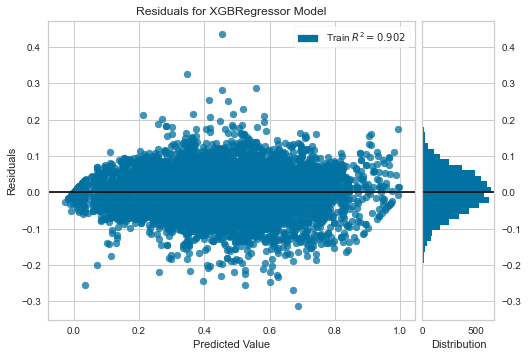

<AxesSubplot:title={'center':'Residuals for XGBRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [186]:
from yellowbrick.regressor import ResidualsPlot 
visualizador = ResidualsPlot(xgb)
visualizador.fit(X_test,y_test)
visualizador.poof()

<AxesSubplot:title={'center':'Residual Histogram'}, ylabel='Frequency'>

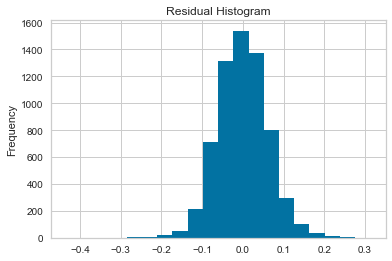

In [187]:
fig, ax = plt.subplots(figsize=(6, 4))
resids = y_test - xgb.predict(X_test)
pd.Series(resids, name="residuals").plot.hist(bins=20, ax=ax, title="Residual Histogram")

### Gráfico de probabilidades. Se as amostras representadas em relação aos quantis estiverem alinhadas, é sinal que os resíduos têm distribuição normal.

In [188]:
from scipy import stats

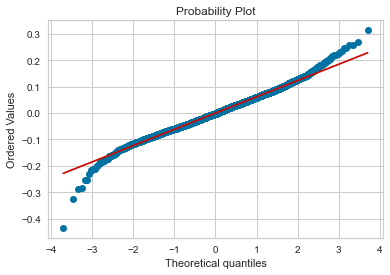

In [189]:
fig, ax = plt.subplots(figsize=(6,4))
a = stats.probplot(resids,plot=ax)

### Gráficos de erros de predição

In [190]:
from yellowbrick.regressor import PredictionError

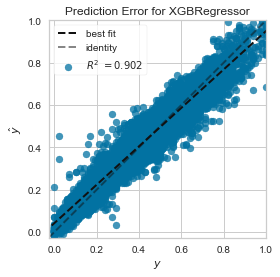

<AxesSubplot:title={'center':'Prediction Error for XGBRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [191]:
fig, ax = plt.subplots(figsize=(6, 4))
pev = PredictionError(xgb)
pev.fit(X_train,y_train)
pev.score(X_test,y_test)
pev.poof()

### XGBoost GridSearchCV

In [200]:
# Definindo os parâmetros para grid search
parameters = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 500]
}

In [199]:
# Definindo os parâmetros para grid search
#Muito pesada para minha maquina
'''parameters = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 500, 1000],
    'min_child_weight': [1, 5, 10],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0]   
    
}'''

"parameters = {\n    'max_depth': [3, 4, 5],\n    'learning_rate': [0.1, 0.01, 0.001],\n    'n_estimators': [100, 500, 1000],\n    'min_child_weight': [1, 5, 10],\n    'colsample_bytree': [0.6, 0.8, 1.0],\n    'gamma': [0.5, 1, 1.5, 2, 5],\n    'subsample': [0.6, 0.8, 1.0]   \n    \n}"

In [201]:
# Criando o objeto GridSearchCV
grid_search = GridSearchCV(xgb, parameters, scoring='accuracy', cv=5)

# Realizando o grid search para encontrar os melhores hiperparâmetros
grid_search.fit(X_train, y_train)

# Imprimindo os melhores hiperparâmetros encontrados
print("Melhores hiperparâmetros encontrados:")
print(grid_search.best_params_)

Melhores hiperparâmetros encontrados:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


In [205]:
# Obtendo as previsões do modelo com os melhores hiperparâmetros
xgb_best = grid_search.best_estimator_
y_pred = xgb_best.predict(X_test)

In [206]:
# Avaliando o modelo
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:', metrics.mean_squared_error(y_test, y_pred))
print('R2:', metrics.r2_score(y_test, y_pred))

MAE: 0.04900485246423556
RMSE: 0.003871036145096077
R2: 0.900371229794024


In [207]:
#Calculando o R2 ajustado
n = len(y_train)

# Número de variáveis independentes (preditoras)
p = X_train.shape[1]
r2_adjusted = 1 - (1 - metrics.r2_score(y_test, y_pred)) * (n - 1) / (n - p - 1)

In [208]:
print('R2 ajustado:', r2_adjusted)

R2 ajustado: 0.9003053377502369


### Randomized Search

In [75]:
from sklearn.model_selection import RandomizedSearchCV

In [76]:
parameters = {
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.1, 0.5, 1],
    'n_estimators': [100, 500, 1000, 2000]
}

In [77]:
# Criando o objeto RandomizedSearchCV
random_search = RandomizedSearchCV(xgb, parameters, n_iter=10, scoring='accuracy', cv=5, 
                                   random_state=42)

In [78]:
# Realizando o random search para encontrar os melhores hiperparâmetros
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          callbacks=None, colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=0, gpu_id=-1,
                                          grow_policy='depthwise',
                                          importance_type=None,
                                          interaction_constraints='',
                                          learning_rate=0.300000012,
                                          max_bin=256, m...
                                          max_delta_step=0, max_depth=6,
                                          max_leaves=0, min_child_weight=1,
                                          missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=100, n_jobs=0,
                                          num_parallel_tree=1, predictor='auto',
                                          random_state=7, reg_alpha=0,
                                          reg_lambda=1, ...),
                   param_distributions={'learning_rate': [0.01, 0.1, 0.5, 1],
                                        'max_depth': [3, 4, 5, 6, 7],
                                        'n_estimators': [100, 500, 1000, 2000]},
                   random_state=42, scoring='accuracy')

In [80]:
# Imprimindo os melhores hiperparâmetros encontrados
print("Melhores hiperparâmetros encontrados:")
print(random_search.best_params_)

Melhores hiperparâmetros encontrados:
{'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.1}


In [81]:
# Obtendo as previsões do modelo com os melhores hiperparâmetros
y_pred = random_search.predict(X_test)

In [82]:
# Avaliando o modelo
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:', metrics.mean_squared_error(y_test, y_pred))
print('R2:', metrics.r2_score(y_test, y_pred))

MAE: 0.049365748270558035
RMSE: 0.003933421497868314
R2: 0.8987656193727838


### Voting Regressor

In [57]:
from sklearn.ensemble import VotingRegressor
import xgboost as xgb

In [58]:
#Divide o dataset em Train and Test 
X_train, X_test, y_train, y_test = train_test_split(X ,y, test_size=0.3, random_state = 7) 

In [59]:
#Redimensionando os dados - PADRONIZAÇÂO - Feature scaling
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import MinMaxScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test) 


#minmax = MinMaxScaler()
#X_train = minmax.fit_transform(X_train)
#X_test = minmax.transform(X_test) 


print("\n--------------------------------\nDataset depois da padronização:\n--------------------------------\n", )

print("\nX_train :\n", X_train[:5])
print("-------------------------")
print("\nX_test :\n", X_test[:5])


--------------------------------
Dataset depois da padronização:
--------------------------------


X_train :
 [[-0.16162371 -0.23197611 -0.46322122  1.08581926 -1.08581926 -1.05315912
   1.05315912  1.36293856 -1.36293856]
 [ 0.71933029  0.26888441  0.1362765  -0.92096359  0.92096359 -1.05315912
   1.05315912  1.36293856 -1.36293856]
 [ 0.71933029  0.76974492  0.62677463  1.08581926 -1.08581926 -1.05315912
   1.05315912  1.36293856 -1.36293856]
 [-0.16162371 -0.23197611  0.35427567 -0.92096359  0.92096359  0.94952413
  -0.94952413  1.36293856 -1.36293856]
 [-0.16162371 -0.23197611 -0.02722288 -0.92096359  0.92096359 -1.05315912
   1.05315912  1.36293856 -1.36293856]]
-------------------------

X_test :
 [[ 0.71933029  1.27060544  1.17177256  1.08581926 -1.08581926 -1.05315912
   1.05315912 -0.73370879  0.73370879]
 [-0.16162371 -0.23197611  0.46327525 -0.92096359  0.92096359 -1.05315912
   1.05315912  1.36293856 -1.36293856]
 [-1.0425777  -0.23197611 -2.75221252 -0.92096359  0.920963

In [221]:
#from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import MinMaxScaler

#sc = StandardScaler()
#X_norm = sc.fit_transform(X) 

In [60]:
r1 = LinearRegression()
r2 = RandomForestRegressor(n_estimators=10, random_state=7)
r3 = KNeighborsRegressor()
r4 = DecisionTreeRegressor(random_state=7,max_depth=9)
r5 = SVR()
r6 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1)
r7 = xgb.XGBRegressor(random_state=7)  
er1 = VotingRegressor([('r1', r1), ('r2', r2), ('r3', r3),('r4', r4),('r5', r5),('r6', r6),('r7', r7)])
er1.fit(X_train, y_train)

VotingRegressor(estimators=[('r1', LinearRegression()),
                            ('r2',
                             RandomForestRegressor(n_estimators=10,
                                                   random_state=7)),
                            ('r3', KNeighborsRegressor()),
                            ('r4',
                             DecisionTreeRegressor(max_depth=9,
                                                   random_state=7)),
                            ('r5', SVR()), ('r6', GradientBoostingRegressor()),
                            ('r7',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynod...
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=7,
                                          reg_alpha=None, reg_lambda=None, ...))])

In [61]:
y_pred = er1.predict(X_test)

In [62]:
# Avaliando o modelo
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:', metrics.mean_squared_error(y_test, y_pred))
print('R2:', metrics.r2_score(y_test, y_pred))

MAE: 0.04800948438699134
RMSE: 0.0037569504371229192
R2: 0.9033074510943192


### Salvando a máquina preditiva

In [64]:
#Comando de Salvamento da Máquina Preditiva
import pickle 
pickle_out = open("maquina_preditiva_burnout.pkl", mode = "wb") 
pickle.dump(er1, pickle_out) 
pickle_out.close()

### Voting Regressor + Grid Search

In [263]:
r7 = LinearRegression()
er2 = VotingRegressor([('r1', dtr), ('r2', rfr_best), ('r3', svr_best),('r4', grb_best),
                      ('r5',xgb_best),('r6', knr_best),('r7', r7)])
er2.fit(X_train, y_train)

VotingRegressor(estimators=[('r1',
                             DecisionTreeRegressor(max_depth=9,
                                                   min_samples_leaf=4,
                                                   min_samples_split=10,
                                                   random_state=7)),
                            ('r2',
                             RandomForestRegressor(max_depth=9,
                                                   max_features='auto',
                                                   min_samples_leaf=2,
                                                   min_samples_split=10,
                                                   n_estimators=150,
                                                   random_state=7)),
                            ('r3', SVR(C=10, epsilon=0.01)),
                            ('r4',
                             GradientBoostingRegressor(learning_rate=0.05,
                                                       max_depth=...
                                          interaction_constraints='',
                                          learning_rate=0.1, max_bin=256,
                                          max_cat_to_onehot=4, max_delta_step=0,
                                          max_depth=3, max_leaves=0,
                                          min_child_weight=1, missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=100, n_jobs=0,
                                          num_parallel_tree=1, predictor='auto',
                                          random_state=7, reg_alpha=0,
                                          reg_lambda=1, ...)),
                            ('r6',
                             KNeighborsRegressor(algorithm='brute',
                                                 n_neighbors=7)),
                            ('r7', LinearRegression())])

In [264]:
y_pred = er2.predict(X_test)

In [265]:
# Avaliando o modelo
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:', metrics.mean_squared_error(y_test, y_pred))
print('R2:', metrics.r2_score(y_test, y_pred))

MAE: 0.04807051106040027
RMSE: 0.0038163977607339073
R2: 0.9017774566635252


### Preenchendo os valores nulos da taxa de burnout com e regressão

In [201]:
#pickle_in = open('maquina_preditiva_burnout.pkl', 'rb') 
#maquina_preditiva = pickle.load(pickle_in)

In [203]:
df1 = pd.read_csv('base/train.csv')
df1.columns = ['id','data_adm','genero','tipo_empresa','ambi_dome_favoravel','nivel_senioridade',
             'horas_trab_dias','nivel_fadiga_mental','taxa_burnout']
df1.isnull().sum()

id                        0
data_adm                  0
genero                    0
tipo_empresa              0
ambi_dome_favoravel       0
nivel_senioridade         0
horas_trab_dias        1381
nivel_fadiga_mental    2117
taxa_burnout           1124
dtype: int64

In [204]:
df1.size

204750

In [205]:
#Trocando pela mediana
mediana = df1['horas_trab_dias'].median()
df1['horas_trab_dias'].fillna(mediana, inplace=True)

In [206]:
#Trocando pela mediana
mediana = df1['nivel_fadiga_mental'].median()
df1['nivel_fadiga_mental'].fillna(mediana, inplace=True)

In [207]:
df1.isnull().sum()

id                        0
data_adm                  0
genero                    0
tipo_empresa              0
ambi_dome_favoravel       0
nivel_senioridade         0
horas_trab_dias           0
nivel_fadiga_mental       0
taxa_burnout           1124
dtype: int64

In [215]:
df1.shape

(22750, 7)

In [211]:
df1[df1.duplicated(keep=False)]
#df1.drop_duplicates(keep='first', inplace=True)

,id,data_adm,genero,tipo_empresa,ambi_dome_favoravel,nivel_senioridade,horas_trab_dias,nivel_fadiga_mental,taxa_burnout


In [212]:
df1.drop(['id'],axis=1, inplace=True)
df1.drop(['data_adm'],axis=1, inplace = True)

In [214]:
df1.shape

(22750, 7)

In [216]:
df1.isnull().sum()

genero                    0
tipo_empresa              0
ambi_dome_favoravel       0
nivel_senioridade         0
horas_trab_dias           0
nivel_fadiga_mental       0
taxa_burnout           1124
dtype: int64

In [217]:
df1.shape

(22750, 7)

In [218]:
df1 = pd.get_dummies(df1, columns=['ambi_dome_favoravel','tipo_empresa','genero'])

In [219]:
df1.head()

,nivel_senioridade,horas_trab_dias,nivel_fadiga_mental,taxa_burnout,ambi_dome_favoravel_No,ambi_dome_favoravel_Yes,tipo_empresa_Product,tipo_empresa_Service,genero_Female,genero_Male
0,2.0,3.0,3.8,0.16,1,0,0,1,1,0
1,1.0,2.0,5.0,0.36,0,1,0,1,0,1
2,2.0,4.0,5.8,0.49,0,1,1,0,1,0
3,1.0,1.0,2.6,0.20,0,1,0,1,0,1
4,3.0,7.0,6.9,0.52,1,0,0,1,1,0


In [220]:
df1.shape

(22750, 10)

In [169]:
#Agora vamos separar os dados nulos
df1_notnull = df1.dropna(subset=['taxa_burnout'])

In [222]:
df1_notnull.shape

(21626, 10)

In [170]:
df1_null = df1[df1['taxa_burnout'].isnull()]

In [223]:
df1_null.shape

(1124, 10)

In [171]:
df1_notnull.head()

,nivel_senioridade,horas_trab_dias,nivel_fadiga_mental,taxa_burnout,ambi_dome_favoravel_No,ambi_dome_favoravel_Yes,tipo_empresa_Product,tipo_empresa_Service,genero_Female,genero_Male
0,2.0,3.0,3.8,0.16,1,0,0,1,1,0
1,1.0,2.0,5.0,0.36,0,1,0,1,0,1
2,2.0,4.0,5.8,0.49,0,1,1,0,1,0
3,1.0,1.0,2.6,0.20,0,1,0,1,0,1
4,3.0,7.0,6.9,0.52,1,0,0,1,1,0


In [172]:
df1_null.head()

,nivel_senioridade,horas_trab_dias,nivel_fadiga_mental,taxa_burnout,ambi_dome_favoravel_No,ambi_dome_favoravel_Yes,tipo_empresa_Product,tipo_empresa_Service,genero_Female,genero_Male
45,2.0,3.0,5.9,NaN,0,1,0,1,0,1
47,3.0,6.0,5.9,NaN,0,1,1,0,1,0
52,1.0,2.0,5.1,NaN,1,0,0,1,1,0
91,1.0,2.0,3.8,NaN,0,1,0,1,1,0
122,3.0,5.0,5.9,NaN,1,0,1,0,1,0


In [224]:
X_test = df1_null.drop(['taxa_burnout'], axis = 1)

In [225]:
X_test.shape

(1124, 9)

In [226]:
predictions = maquina_preditiva.predict(X_test)

In [228]:
print(predictions.shape)
display(predictions)

(1124,)


array([5.89502596e+10, 5.89502596e+10, 5.89502596e+10, ...,
       5.89502596e+10, 5.89502596e+10, 5.89502596e+10])

In [229]:
df1.isnull().sum()

nivel_senioridade             0
horas_trab_dias               0
nivel_fadiga_mental           0
taxa_burnout               1124
ambi_dome_favoravel_No        0
ambi_dome_favoravel_Yes       0
tipo_empresa_Product          0
tipo_empresa_Service          0
genero_Female                 0
genero_Male                   0
dtype: int64

In [231]:
print(df1.loc[df1['taxa_burnout'].isnull()])

       nivel_senioridade  horas_trab_dias  nivel_fadiga_mental  taxa_burnout  \
45                   2.0              3.0                  5.9           NaN   
47                   3.0              6.0                  5.9           NaN   
52                   1.0              2.0                  5.1           NaN   
91                   1.0              2.0                  3.8           NaN   
122                  3.0              5.0                  5.9           NaN   
...                  ...              ...                  ...           ...   
22699                3.0              6.0                  6.1           NaN   
22706                2.0              5.0                  6.3           NaN   
22711                3.0              5.0                  5.4           NaN   
22733                2.0              3.0                  4.5           NaN   
22741                2.0              5.0                  6.0           NaN   

       ambi_dome_favoravel_No  ambi_dom

In [232]:
df1.loc[df1['taxa_burnout'].isnull(), 'taxa_burnout'] = predictions

In [255]:
df1.isnull().sum()

nivel_senioridade          0
horas_trab_dias            0
nivel_fadiga_mental        0
taxa_burnout               0
ambi_dome_favoravel_No     0
ambi_dome_favoravel_Yes    0
tipo_empresa_Product       0
tipo_empresa_Service       0
genero_Female              0
genero_Male                0
dtype: int64

In [257]:
df1.to_csv('base/train_processado_notnull.csv',index = False)